In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import ROOT
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.integrate import simpson
from astropy.cosmology import FlatLambdaCDM, z_at_value
import astropy.units as u

mpl.rcParams.update({
    'text.usetex':     False,
    'mathtext.fontset':'cm',                
    'font.family':     'serif',
    'font.serif':      ['DejaVu Serif'],    
    'font.size':       12,
    'axes.labelsize':  14,
})

cosmo = FlatLambdaCDM(H0=70 * u.km/u.s/u.Mpc, Om0=0.3)

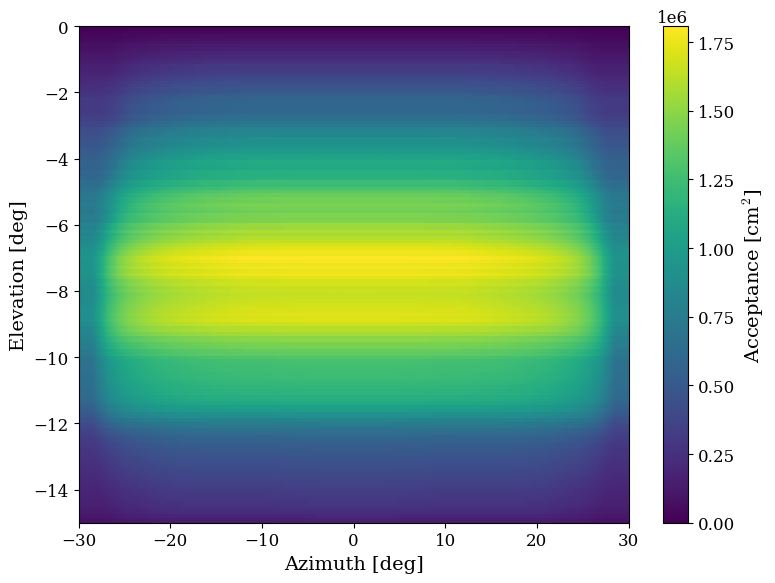

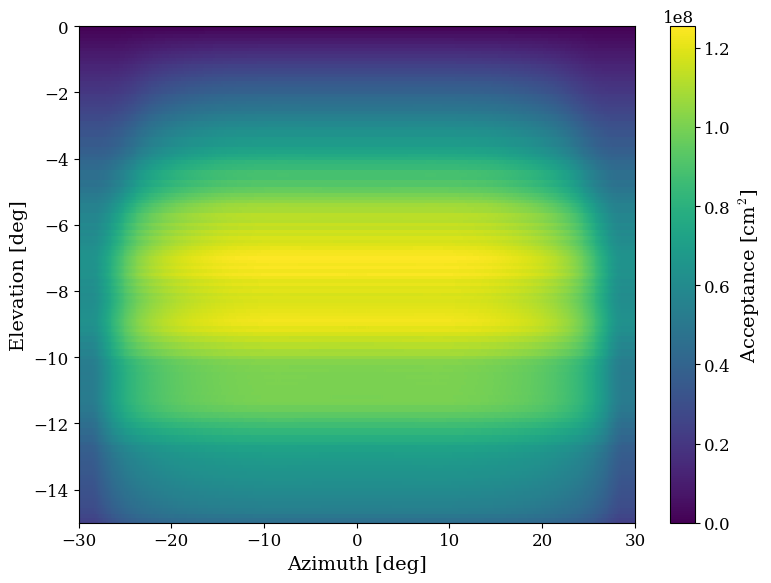

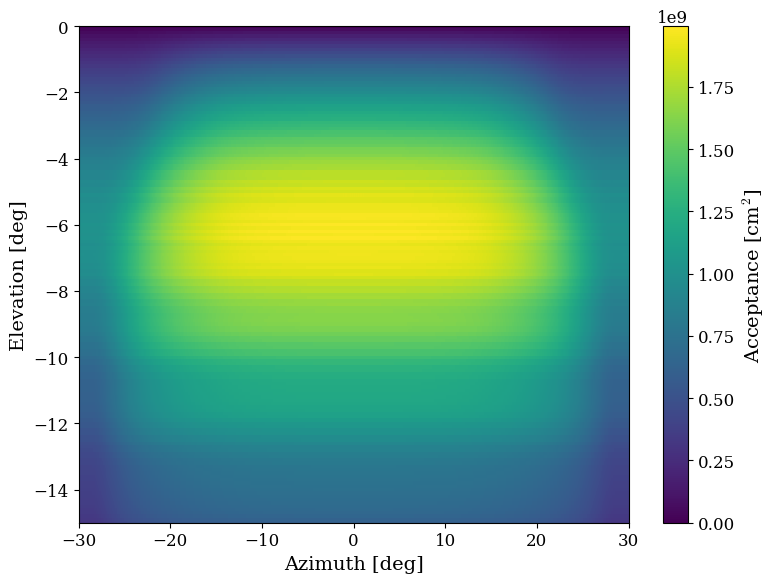

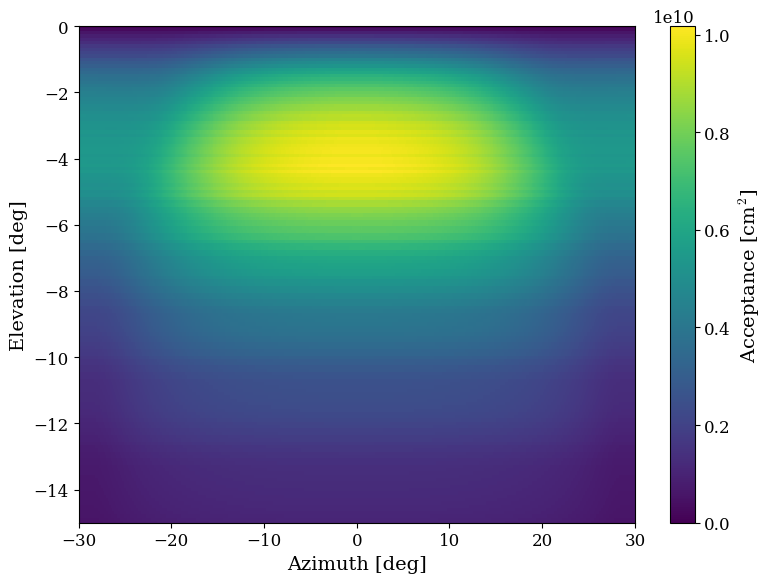

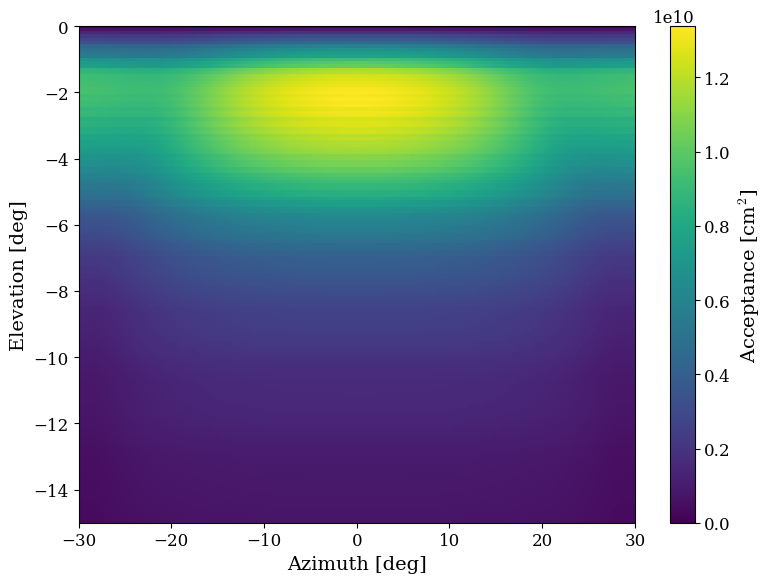

In [3]:
# THIS PART OF THE CODE CALCULATES ON WORKS WITH THE 60FoV CONFIGURATION
# THIS PART USES THE ROOT FILES TO MAKE THE PLOTS.


#This cell is only to visualize the acceptance     
output_folder   = 'skymaps_60FoV'
latitude_deg    = 38.5217                       # degrees
lst_hours       = 0.00                      # local sidereal time (hours)

energies = [5,6,7,8,9] #log10(Emin) [GeV]

os.makedirs(output_folder, exist_ok=True)


for i in energies:
    f = ROOT.TFile.Open(f"../effective_areas/files/PointSourceAcceptance_FoV60.0deg_Index2.0_Emin{i}.5_Emax{i+1}.5.root")

    # get TH2 histogram
    h2 = f.Get("skyAcceptance")
    if not h2:
        raise ValueError("Could not find a histogram named 'skyAcceptance' in the file.")
    
    # Get binning info
    nx = h2.GetNbinsX()
    ny = h2.GetNbinsY()
    
    # pull out just the bin contents into a (nx×ny) NumPy array
    acceptance = np.zeros((nx, ny))
    for i in range(1, nx+1):
        for j in range(1, ny+1):
            acceptance[i-1, j-1] = h2.GetBinContent(i, j)
    
    # Also get the bin‐center coordinates
    x_centers = np.array([h2.GetXaxis().GetBinCenter(i) for i in range(1, nx+1)])
    y_centers = np.array([h2.GetYaxis().GetBinCenter(j) for j in range(1, ny+1)]) 

    # now plot
    plt.figure(figsize=(8,6))
    mesh = plt.pcolormesh(
        x_centers,     # x bin edges
        y_centers,     # y bin edges
        acceptance.T,      # transpose so that data[:,j] aligns with y
        shading='auto'
    )
    plt.xlabel("Azimuth [deg]")
    plt.ylabel("Elevation [deg]")
    cbar = plt.colorbar(mesh)
    cbar.set_label("Acceptance [cm$^2$]")
    plt.xlim([-30,30])
    plt.ylim([-15,0])
    plt.tight_layout()
    plt.show()

# Probability of detection if the GRB falls within the FoV

The probability of detecting at least one neutrino is

$$P_{n \geq 1}(d_L) = \frac{1}{\Omega_{\text{norm}}} \int_{\Omega} d\Omega  p_{n \geq 1}(\phi, \theta, d_L)$$


where $ p_{n \geq 1}$ represents the Poisson probability of detecting at least one neutrino

$$ p_{n \geq 1}(\phi, \theta, d_L) = 1 - \exp\left(-N_\nu(\phi, \theta, d_L)\right) $$

to account for detection only within the FoV we normalize to the solid angle in the field of view.

Note that $N_\nu$ is taken from the skymaps previously calculated. 

In [4]:
# THIS IS TO CALCULATE THE PROBABILITY OF DETECTING N>1 NEUTRINOS IN THE TELESCOPE FIELD OF VIEW

# x_centers = 1D array of azimuth bin centers (degrees)
# y_centers = 1D array of elevation bin centers (degrees)
nAz, nEl = len(x_centers), len(y_centers)

# bin widths (radians)
dAz = np.deg2rad(x_centers[1] - x_centers[0])
dEl = np.deg2rad(y_centers[1] - y_centers[0])

# compute cos(El) for each row
el_rad    = np.deg2rad(y_centers)           # shape (nEl,)
cos_el    = np.cos(el_rad)                  # shape (nEl,)

# every pixel in a given elevation row has the same Ω:
dOmega_row = dAz * dEl * cos_el            # shape (nEl,)

# tile into full (nAz × nEl) array and flatten:
dOmega2d   = np.tile(dOmega_row, (nAz, 1)) # shape (nAz, nEl)
dOmega_flat = dOmega2d.ravel()             # length = nAz*nEl

def probability(dOmega_flat,number_events_flat,onlyFoV = True):
    #probability of detecting at least one neutrino if the expected number of events is number_events_flat, does the full array
    p = 1-np.exp(-number_events_flat)
    #adding all of the probabilities for each solid angle, each value in dOmega_flat corresponds to the same position in p
    integral_prob = sum(dOmega_flat*p)
    if onlyFoV == False:  
        return integral_prob/(4*np.pi) #normalizing to the whole sky
    else:
        normalization = 0
        for i in range(len(number_events_flat)):
            if number_events_flat[i] > 0:
                normalization = normalization + dOmega_flat[i]
        #print(normalization)
        return integral_prob/normalization #normalizing to the field of view

def get_FoV(dOmega_flat,number_events_flat):
    normalization = 0
    for i in range(len(number_events_flat)):
        if number_events_flat[i] > 0:
            normalization = normalization + dOmega_flat[i]
    return normalization

In [5]:
sum(dOmega_flat)

np.float64(12.569858082031379)

In [53]:
dL_sGRB = np.logspace(0,3,15)
prob_dL_sGRB = []
for d in tqdm(dL_sGRB):
    npz_path = f'skymaps_expected_events_sGRBs/events_{float(d):.3f}.npz'
    data = np.load(npz_path)
    n = data['events']
    prob = probability(dOmega_flat,n)
    prob_dL_sGRB.append(prob)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:31<00:00,  2.08s/it]


(10, 1000.0)

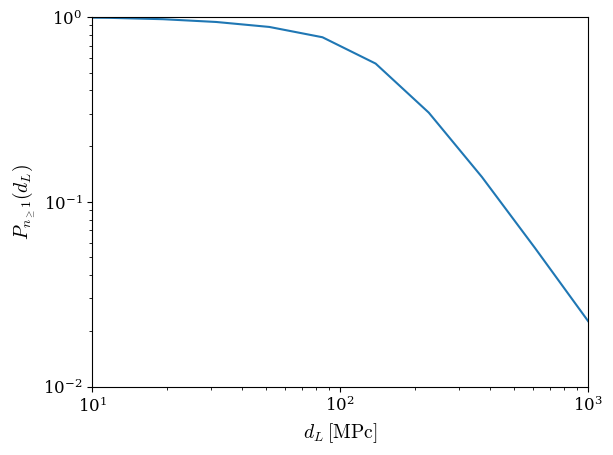

In [54]:
# Short GRBs
plt.plot(dL_sGRB,prob_dL_sGRB)
plt.ylabel(r'$P_{n_\geq 1}(d_L)$')
plt.xlabel(r'$d_L \: [\rm{MPc}]$')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-2,1])
plt.xlim([10,1e3])

In [8]:
dL_photo = np.logspace(2,6,15)
prob_dL_photo = []
for d in tqdm(dL_photo):
    npz_path = f'skymaps_expected_events_Photosphere_change_dL/events_{float(d):.3f}.npz'
    data = np.load(npz_path)
    n = data['events']
    prob = probability(dOmega_flat,n)
    prob_dL_photo.append(prob)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:16<00:00,  1.08s/it]


(100.0, 1000000.0)

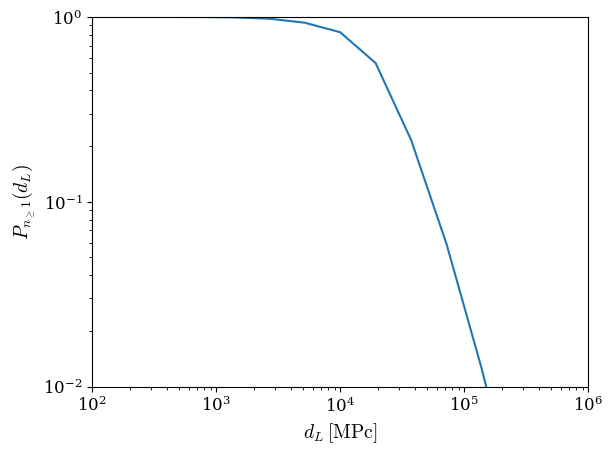

In [9]:
# BOAT-like GRBs photosphere model
plt.plot(dL_photo,prob_dL_photo)
plt.ylabel(r'$P_{n_\geq 1}(d_L)$')
plt.xlabel(r'$d_L \: [\rm{MPc}]$')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-2,1])
plt.xlim([1e2,1e6])

In [10]:
dL_IS = np.logspace(2,6,15)
prob_dL_IS = []
for d in tqdm(dL_IS):
    npz_path = f'skymaps_expected_events_IShock_change_dL/events_{float(d):.3f}.npz'
    data = np.load(npz_path)
    n = data['events']
    prob = probability(dOmega_flat,n)
    prob_dL_IS.append(prob)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:17<00:00,  1.18s/it]


(100.0, 1000000.0)

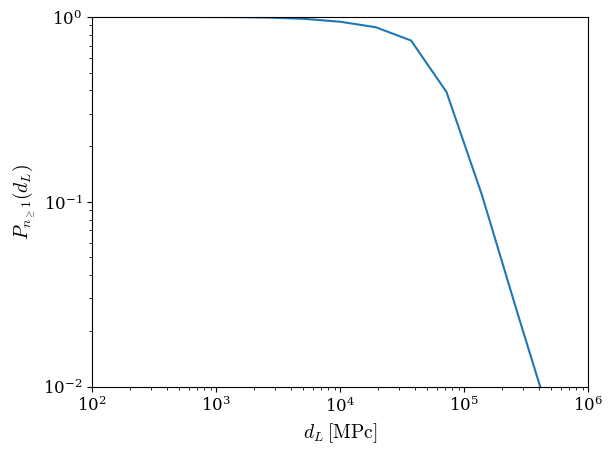

In [11]:
# BOAT-like GRBs Internal Shock Model
plt.plot(dL_IS,prob_dL_IS)
plt.ylabel(r'$P_{n_\geq 1}(d_L)$')
plt.xlabel(r'$d_L \: [\rm{MPc}]$')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-2,1])
plt.xlim([1e2,1e6])

In [12]:
ICGEN2 = np.array([
    [10.213741098403561, 0.9789375956402515],
    [10.940460217899238, 0.9720158430111671],
    [12.22520154244969,  0.9583188161579163],
    [13.164458054677555, 0.9448147990647094],
    [13.95279806461656,  0.9315010719612002],
    [15.024785009002379, 0.8990317687798847],
    [15.924528782284385, 0.8676942470648648],
    [16.6125491989049,   0.8374490563456362],
    [17.6073745951485,   0.8025431882697138],
    [18.271242540499323, 0.785639699122215 ],
    [19.675013552622865, 0.7422840144634141],
    [20.20208045887528,  0.716410244225541 ],
    [20.853231472054304, 0.691438355172333 ],
    [22.45537548523166,  0.6395215180105815],
    [24.308798306580908, 0.5628403287214264],
    [25.901089063871623, 0.520579309390189 ],
    [28.18755491278229,  0.46470813736898925],
    [29.56128486773668,  0.43595865140187656],
    [32.85848469330768,  0.378278813779565 ],
    [35.75912732315746,  0.32590953934853084],
    [38.30342928576358,  0.28887421794371715],
    [41.90571443100131,  0.24888219976962894],
    [46.82671427854296,  0.2054891548762576 ],
    [51.5021652435089,   0.17208669884038413],
    [59.40502619658581,  0.13329301637123211],
    [67.08664146946096,  0.10697340233265573],
    [76.16318910775479,  0.08344831379259411],
    [86.011788698384,    0.06697087580684001],
    [95.60535189978873,  0.05336699231206313],
    [109.11576094041699, 0.042225792771758565],
    [124.53538477726714, 0.032475529468303926],
    [131.29702310458808, 0.02919653269995252],
    [158.82486121138558, 0.02033135904212722],
    [192.12420771125952, 0.014157988030563673],
    [216.96763162222618, 0.01096633814849359]
])

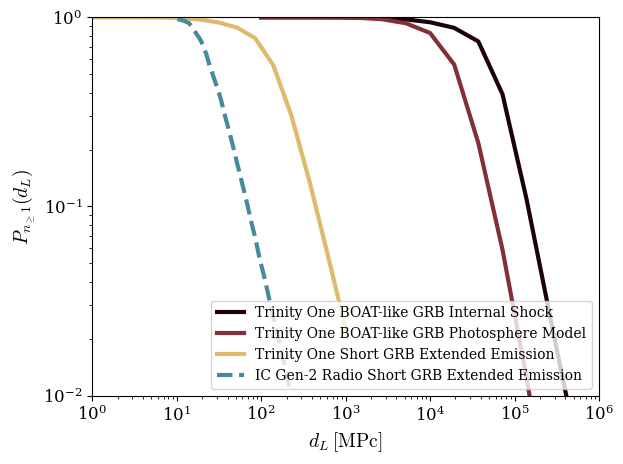

In [13]:
plt.plot(dL_IS,prob_dL_IS, label = 'Trinity One BOAT-like GRB Internal Shock', color = '#1E000E', lw = '3')
plt.plot(dL_photo,prob_dL_photo, label = 'Trinity One BOAT-like GRB Photosphere Model', color = '#823038', lw = '3')
plt.plot(dL_sGRB,prob_dL_sGRB, label = 'Trinity One Short GRB Extended Emission', color = '#DEBA6F', lw = '3')
plt.plot(ICGEN2[:,0],ICGEN2[:,1], label = 'IC Gen-2 Radio Short GRB Extended Emission', color = '#468C98', lw = '3', ls = '--')
plt.ylabel(r'$P_{n_\geq 1}(d_L)$')
plt.xlabel(r'$d_L \: [\rm{MPc}]$')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-2,1])
plt.xlim([1e0,1e6])
plt.legend(loc='lower right', fontsize='small')
plt.tight_layout()
plt.savefig('outputs/Detection_Prob.png')

# Operation time needed for short GRB detection

The probability of detenting at least one neutrino within a distance horizon is

$$ P_{n \geq 1} (d_L^{UL}) = 1 - exp(-T_{op}I(d^{UL}))$$

where 

$$ I(d^{UL}) = 4 \pi \int_0^{d^{UL}} d(d_{com}) R_{app}(z) \dfrac{d^2_{com}}{1+z} P_{n \geq 1 }(d_L)$$.

The comoving distance is $d_{com} = d_L/(1+z)$. Following Ref. 1. we do

$$ I(d^{UL}) = \int_0^{d^{UL}} d(d_{com}) R_{app}(z) \dfrac{d^2_{com}}{1+z} \tilde N_\nu$$

with 
$$ \tilde N_\nu = \int d E_\nu \langle A_{eff}\rangle \phi_\nu = \int d\Omega  \int d E_\nu A_{eff} \phi_\nu \approx  \int d E_\nu \tilde A_{eff} \phi_\nu$$

where $\tilde A_{eff}$ is the direction averaged effective area times the instantaneous field of view. Note that Ref. 1. uses the daily field of view instead of the instantaneous but we decided to use the instantaneous


(100000.0, 1000000000000.0)

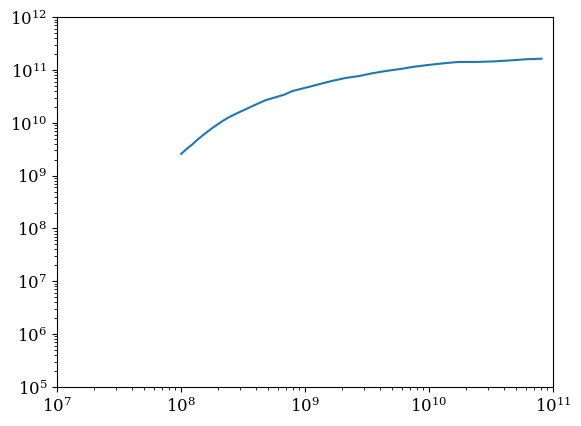

In [14]:
# This is GRAND's effective area times 
grand_red = np.array([
    [100104521.66885544,  2581879405.833583],
    [111656420.97622610,  3264586938.6753016],
    [122099086.35837350,  3847271527.4457817],
    [136189122.72855590,  4864577466.189536 ],
    [158070431.88921314,  6446379457.384054 ],
    [178085498.49869290,  7961940410.136483 ],
    [208777975.58273658, 10306244392.187086 ],
    [237580343.99450725, 12434097397.596273 ],
    [278562944.53634240, 15001272258.79818  ],
    [317020230.25552810, 17268851875.574043 ],
    [360786774.99101530, 19879196907.823368 ],
    [410595553.80266690, 22884119485.614384 ],
    [481444227.45471096, 26968625122.110264 ],
    [570222746.68173860, 30325289046.725925 ],
    [675372062.41371860, 34099741889.085815 ],
    [791908187.56292700, 40186084343.14343  ],
    [928673999.62524460, 44140028123.29449  ],
    [1089059831.8399303,  48483003869.91188  ],
    [1315855810.6975880,  54517466112.991425 ],
    [1671055918.0959754,  62758280144.1867   ],
    [2101181472.2608530,  70569522058.71107  ],
    [2749609779.1452760,  77512918693.9662   ],
    [3491987238.2825150,  87160604354.382    ],
    [4434995014.6069000,  95736412002.58391  ],
    [5920503548.1187030, 105156000821.92018  ],
    [7519329805.1064030, 115502391175.48373  ],
    [9550333243.8363700, 123924923888.35063  ],
    [12498126926.876839, 132961634858.2847   ],
    [17191602366.902912, 142657310486.7543   ],
    [24126954476.604010, 142657310486.7543   ],
    [33190342906.572445, 146043845721.56653  ],
    [46113817270.654800, 153060003037.7578   ],
    [60954445887.638780, 160413226686.61328  ],
    [80574682873.615170, 164221268787.2982   ]
])
plt.loglog(grand_red[:,0],grand_red[:,1])
plt.xlim([1e7,1e11])
plt.ylim([1e5,1e12])

In [197]:
trinity_FoV = 0.27 #sr
azimuth_rotation_trinity_FoV = trinity_FoV*4 #sr
def R(z):
    N = 300*1e-9*0.1# Mpc^-3 yr^-1 * 1%
    if z>0.9:
        return N*np.exp(-(z-0.9)/0.26)
    else:
        return N*np.exp((z-0.9)/0.39)
        
def expected_neutrino(fluence,Aeff,E):
    dNdE =  fluence*E**(-2)
    y = dNdE*Aeff
    return simpson(y*E,x = np.log(E))

def integral_UL( DUL, prob):
    dL = np.logspace(np.log10(0.1),np.log10(DUL),100)
    Integrand = []
    dcom = []
    for i in dL:
        z =  z_at_value(cosmo.luminosity_distance, i * u.Mpc)
        dcom_i = i/(1+z)
        Integrand.append(R(z)*dcom_i**2*np.exp(prob(np.log(i)))/(1+z))
        dcom.append(dcom_i)
    Integrand = np.array(Integrand)
    
    dcom = np.array(dcom)
   
    return simpson(Integrand*dcom, x = np.log(dcom)) 

def probability_UL(Top, DUL, prob):
    I = integral_UL(DUL, prob) 
    p = 1-np.exp(-Top*I)
    return p

def event_number_dL(dL, experiment = 'trinity'):
    # Source distance scaling
    dL0 = 300                    # Mpc
    dLnew = dL                  # Mpc
    pc2cm = 3.086e18             # 1 parsec in cm
    erg2gev = 624.2              # 1 erg in GeV
    
    dL0_cm   = dL0 * 1e6 * pc2cm
    dLnew_cm = dLnew * 1e6 * pc2cm
    z0 =  z_at_value(cosmo.luminosity_distance, dL0_cm * u.cm)
    znew = z_at_value(cosmo.luminosity_distance, dLnew_cm * u.cm)
    grb = np.genfromtxt('files/extended_emission_murase.csv', delimiter=',')
    E_grb_native = grb[:,0]    # GeV
    flux_native  = grb[:,1]
    
    # scale flux 
    dL_factor = 3*(dL0**2/(dLnew)**2)*((1+znew)/(1+z0))
    fluence_vals = dL_factor * erg2gev * flux_native * 1e9
    
    # build an interpolator: x must match the units of E when calling below
    # here we assume E_grb_native * 1e9 gives energy in eV
    flu_interp = interp1d(E_grb_native * 1e9, fluence_vals, fill_value='extrapolate')
            
    if experiment == 'grand':
        energies = grand_red[:,0]*1e9
        fluence_E   = flu_interp(energies) 
        fluence_E = np.clip(fluence_E, 0, None)
        return expected_neutrino(fluence_E,grand_red[:,1],energies)
    elif experiment == 'trinity':
        energies = Aeff[:,0]*1e9
        fluence_E   = flu_interp(energies) 
        fluence_E = np.clip(fluence_E, 0, None)
        return expected_neutrino(fluence_E,Aeff[:,1]*azimuth_rotation_trinity_FoV/3,energies)
    else:
        print('Experiment not considered')


In [198]:
dL = np.logspace(1,3,1000)
n_nu_grand = []
for d in tqdm(dL):
    n_grand = event_number_dL(d, experiment = 'grand')
    n_nu_grand.append(1-np.exp(-n_grand))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.91it/s]


In [199]:
n_dL_grand = interp1d(dL,n_nu_grand, fill_value='extrapolate')
# I have to do the interpolation for the probability and test it
Toperation = np.linspace(0,10,100)
Prob_UL_grand = probability_UL(Toperation,1e3,n_dL_grand)

Text(0.5, 1.0, 'GRAND')

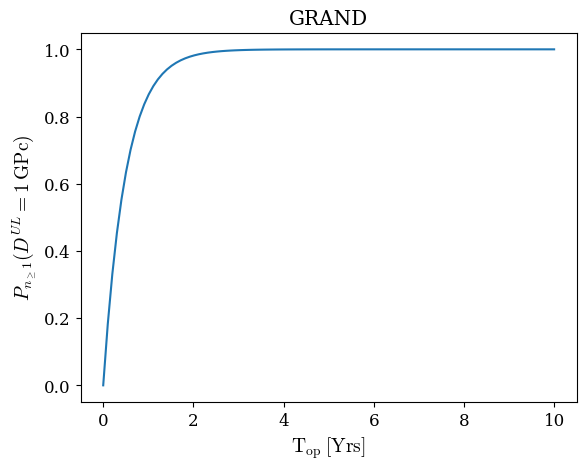

In [200]:
plt.plot(Toperation,Prob_UL_grand)
plt.ylabel(r'$P_{n_\geq 1}(D^{UL} = 1 \: \rm{GPc})$')
plt.xlabel(r'$\rm{T_{op}} \: [\rm{Yrs}]$')
plt.title(r'GRAND')

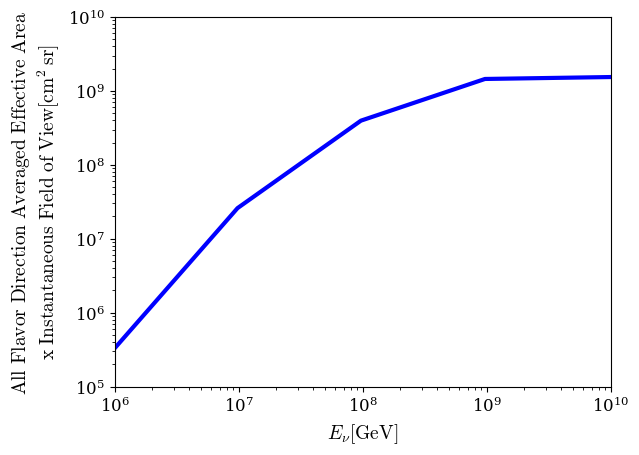

In [201]:

Aeff = np.array([
    [999362.9705021202, 916117.101533752],
    [9775707.237408124, 72001979.23553275],
    [96726901.36251712, 1098435598.0092568],
    [967824721.9304067, 4023768215.8895645],
    [9699897500.859245, 4270186612.458323]
]) # Trinity-One direction averaged effective area cm^2

plt.loglog(Aeff[:,0],Aeff[:,1]*azimuth_rotation_trinity_FoV/3, color = 'blue', lw = 3, label ='Trinity' ) # FIX THE NORMALIZATION
plt.xlim([1e6,1e10])
plt.ylim([1e5,1e10])
#plt.legend()
plt.xlabel(r'$E_\nu \rm{[GeV]}$')
plt.ylabel(
    r'$\rm{All\ Flavor\ Direction\ Averaged\ Effective\ Area}$' + '\n' +
    r'$\rm{x\ Instantaneous\ Field\ of\ View }[\rm{cm}^2\:\rm{sr}]$'
)
plt.tick_params(
    axis='y',        # apply to y axis
    which='both'    # major and minor ticks
)
plt.savefig('Direction_xFoV.png', bbox_inches='tight', pad_inches=0.1)

In [202]:
n_nu_trinity = []
for d in tqdm(dL):
    n_trinity = event_number_dL(d)
    n_nu_trinity.append(1-np.exp(-n_trinity))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 260.79it/s]


In [194]:
n_dL_trinity = interp1d(dL,n_nu_trinity, fill_value='extrapolate')

In [195]:
# I have to do the interpolation for the probability and test it
Toperation = np.linspace(0,10,100)
Prob_UL_trinity = probability_UL(Toperation*0.2,1e3,n_dL_trinity)

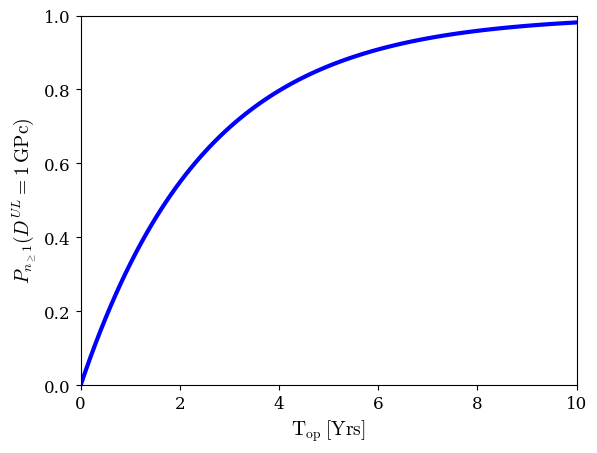

In [203]:
plt.plot(Toperation,Prob_UL_trinity, color = 'blue', lw = 3, label ='Trinity One')
#plt.plot(Toperation, Prob_UL_grand, color = 'orange', lw = 3, label ='GRAND' )
#plt.legend()
plt.xlim([0,10])
plt.ylim([0,1])
plt.ylabel(r'$P_{n_\geq 1}(D^{UL} = 1 \: \rm{GPc})$')
plt.xlabel(r'$\rm{T_{op}} \: [\rm{Yrs}]$')
plt.savefig('detection_probability_exposuretime.png')
#plt.grid()

# References

1. Kumiko Kotera, Mainak Mukhopadhyay, Rafael Alves Batista, Derek Fox, Olivier Martineau-Huynh, Kohta Murase, Stephanie Wissel, Andrew Zeolla (2025). *Observational strategies for ultrahigh-energy neutrinos: the importance of deep sensitivity for detection and astronomy*. arXiv:[2504.08973](https://arxiv.org/abs/2504.08973).

2. Mainak Mukhopadhyay, Kumiko Kotera, Stephanie Wissel, Kohta Murase, Shigeo S. Kimura (2024). *Ultrahigh-energy neutrino searches using next-generation gravitational wave detectors at radio neutrino detectors: GRAND, IceCube-Gen2 Radio, and RNO-G*. **Phys. Rev. D 110, 063004**. doi:[10.1103/PhysRevD.110.063004](https://doi.org/10.1103/PhysRevD.110.063004).
